Node_0_to_Node_1: Fidelity = 0.2500
Node_0_to_Node_2: Fidelity = 0.2500
Node_0_to_Node_3: Fidelity = 0.2500
Node_0_to_Node_4: Fidelity = 0.2500
Node_1_to_Node_2: Fidelity = 0.2500
Node_1_to_Node_3: Fidelity = 0.2500
Node_1_to_Node_4: Fidelity = 0.2500
Node_2_to_Node_3: Fidelity = 0.2500
Node_2_to_Node_4: Fidelity = 0.2500
Node_3_to_Node_4: Fidelity = 0.2500


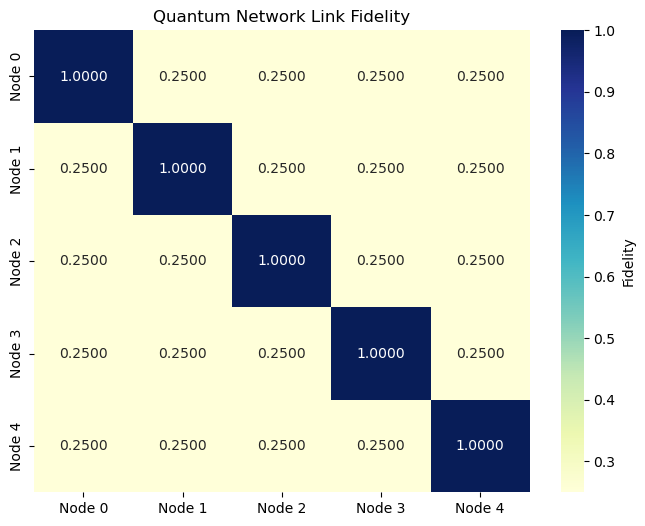

In [ ]:
import math
import random
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_counts
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit_aer.noise import NoiseModel, amplitude_damping_error, phase_damping_error, depolarizing_error

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -------------------------
# Parameters
# -------------------------
NUM_NODES = 5
REPEATERS_PER_LINK = 2
LINK_QUBITS = 2  # Bell pair
backend = AerSimulator()

# -------------------------
# Noise Model
# -------------------------
def get_noise_model():
    noise_model = NoiseModel()
    
    # Decoherence
    amp_error = amplitude_damping_error(0.1)
    phase_error = phase_damping_error(0.05)
    
    # Random 2-qubit crosstalk
    crosstalk_prob = random.uniform(0.01, 0.05)
    depol_error = depolarizing_error(crosstalk_prob, 2)

    for gate in ['u1', 'u2', 'u3']:
        noise_model.add_all_qubit_quantum_error(amp_error, [gate])
        noise_model.add_all_qubit_quantum_error(phase_error, [gate])

    noise_model.add_all_qubit_quantum_error(depol_error, ['cx'])
    return noise_model

# -------------------------
# Bell Pair Generator
# -------------------------
def create_bell_pair():
    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)
    qc.h(qr[0])
    qc.cx(qr[0], qr[1])
    return qc

# -------------------------
# Repeater Chain Simulator
# -------------------------
def simulate_repeater_chain():
    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)
    for _ in range(REPEATERS_PER_LINK + 1):
        bell = create_bell_pair()
        qc = qc.compose(bell)
    qc.save_density_matrix()
    return qc

# -------------------------
# Fidelity Check
# -------------------------
from qiskit.quantum_info import state_fidelity

def compute_fidelity(output_dm):
    ideal = create_bell_pair()
    ideal_state = Statevector.from_instruction(ideal)
    ideal_dm = DensityMatrix(ideal_state)
    return state_fidelity(ideal_dm, DensityMatrix(output_dm))


# -------------------------
# Network Simulation
# -------------------------
def simulate_network():
    results = {}
    noise_model = get_noise_model()

    for i in range(NUM_NODES):
        for j in range(i + 1, NUM_NODES):
            circuit = simulate_repeater_chain()
            transpiled = transpile(circuit, backend)
            result = backend.run(transpiled, noise_model=noise_model).result()
            output_dm = result.data(0)['density_matrix']
            fidelity = compute_fidelity(output_dm)
            results[f'Node_{i}_to_Node_{j}'] = fidelity

    return results





# -------------------------
# Run and Print
# -------------------------
if __name__ == '__main__':
    network_results = simulate_network()
    for link, fid in network_results.items():
        print(f"{link}: Fidelity = {fid:.4f}")
    
